In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL

In [102]:
def graficar(s: pd.Series, t, resc = None, linea_cero=False):
    fig, ax = plt.subplots(figsize=[8,4])
    s.plot(ax=ax)
    ax.set_title(t)
    if resc is not None:        
        y1, y2 = ax.get_ylim()
        resc1 = resc == 1
        ax.fill_between(resc1.index, y1=y1, y2=y2, where=resc1, facecolor='grey', alpha=0.4)
    if linea_cero:
        ax.axhline(y=0,color='grey',linestyle='--')

def graficar2(s1: pd.Series, t1,s2: pd.Series, t2, linea_cero=False):
    fig, ax = plt.subplots(1,2,figsize=[10,4])
    s1.plot(ax=ax[0])
    s2.plot(ax=ax[1])
    ax[0].set_title(t1)
    ax[1].set_title(t2)
    if linea_cero:
        ax[0].axhline(y=0,color='grey',linestyle='--')
        ax[1].axhline(y=0,color='grey',linestyle='--')

def graficar_multiple(df):
    for col in df.columns:
        if col == 'Class':
            graficar(df[col], col)
            continue
        graficar(df[col],col,resc=df['Class'])

# Carga de datos
Se extrayeron los datos de [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/tags/series?t=monthly)

Indicadores Macroeconómicos

In [103]:
df = pd.read_csv('../data/PERU_DATA.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df['Recesion'] = df['Recesion'].astype('int')
df = df.rename(columns={'Recesion':'Class'})
df.head()

,PN02312FM,PN38705PM,PN02028AM,PD37972BM,PD37974BM,PD37976BM,Class
DATE,,,,,,,
1995-02-01,1272.226473,38.433894,55.767947,31.035781,59.493583,42.826815,0
1995-03-01,1495.857345,38.961215,59.344344,30.136709,70.994501,52.061686,0
1995-04-01,1650.980245,39.344815,52.743337,29.452419,70.873138,45.182163,0
1995-05-01,1567.141857,39.673230,63.550977,30.898029,72.091964,51.892059,0
1995-06-01,1452.243775,39.994072,62.733200,32.893440,69.770364,47.712314,0


# Descripción

Características de dataset de macroeconomia

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 332 entries, 1995-02-01 to 2022-09-01
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PN02312FM  332 non-null    float64
 1   PN38705PM  332 non-null    float64
 2   PN02028AM  332 non-null    float64
 3   PD37972BM  332 non-null    float64
 4   PD37974BM  332 non-null    float64
 5   PD37976BM  332 non-null    float64
 6   Class      332 non-null    int32  
dtypes: float64(6), int32(1)
memory usage: 19.5 KB


Metadatos del dataset

In [105]:
md = pd.read_csv('../data/PERU_METADATA.csv')
md

,Feature,Description
0,PN02312FM,Ingresos corrientes del gobierno central (mill...
1,PN38705PM,Índice de precios Lima Metropolitana (índice D...
2,PN02020AM,Producción manufacturera (índice 2007 = 100) -...
3,PN02028AM,Producción manufacturera (índice 2007 = 100) -...
4,PD37972BM,Indicadores de coyuntura - Volumen de exportac...
5,PD37974BM,Indicadores de coyuntura - Volumen de importac...
6,PD37976BM,Indicadores de coyuntura - Volumen de importac...


Estadisticas descriptivas del dataset

In [106]:
df.describe()

,PN02312FM,PN38705PM,PN02028AM,PD37972BM,PD37974BM,PD37976BM,Class
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000
mean,5962.681531,69.824862,96.893401,106.152020,136.997651,110.277013,0.117470
std,3728.593018,16.355042,29.867365,53.145446,70.576452,50.474622,0.322465
min,1272.226473,38.433894,44.000495,27.040935,40.847639,38.761128,0.000000
25%,2381.603673,56.971250,64.365560,53.804463,70.525440,57.854372,0.000000
50%,5216.169214,69.185041,104.606060,103.837984,114.370742,108.518908,0.000000
75%,8461.483993,83.963561,124.955948,144.572937,209.385636,155.790121,0.000000
max,22599.104803,106.679849,144.397027,264.058785,281.894625,216.507003,1.000000


Grafica de las caracteristicas

In [107]:
#graficar_multiple(df)

# Preprocesamiento

## Ajuste Estacional

Segun lo anterior, se observa que presentan estacionalidad.
Se procede a realizar un ajuste estacional, descomponiendo la serie y eliminando 
su componente de estacionalidad.

In [108]:
for col in df.columns:
    if col == 'Class':
        continue
    res = STL(df[col], period = 12).fit()
    df[col] = res.trend

## Transformaciones

Se transforma las series a variaciones segun la observacion anterior usando diferencia logaritmica

In [109]:
df_diff = df.copy()
for col in df_diff.columns:
    if col == 'Class':
        continue
    df_diff[col] = np.log(df_diff[col]) - np.log(df_diff[col].shift(1))
df_diff = df_diff.dropna()

# Seleccion de Caracteristicas

In [110]:
corr = df_diff.corr()
corr.style.background_gradient(cmap='coolwarm')

,PN02312FM,PN38705PM,PN02028AM,PD37972BM,PD37974BM,PD37976BM,Class
PN02312FM,1.000000,0.212273,0.791249,0.653027,0.556375,0.566834,-0.430561
PN38705PM,0.212273,1.000000,-0.112058,0.066657,-0.095317,-0.146610,-0.039268
PN02028AM,0.791249,-0.112058,1.000000,0.722907,0.744012,0.793346,-0.400376
PD37972BM,0.653027,0.066657,0.722907,1.000000,0.479901,0.666105,-0.359304
PD37974BM,0.556375,-0.095317,0.744012,0.479901,1.000000,0.778404,-0.426299
PD37976BM,0.566834,-0.146610,0.793346,0.666105,0.778404,1.000000,-0.415544
Class,-0.430561,-0.039268,-0.400376,-0.359304,-0.426299,-0.415544,1.000000


In [111]:
def features_sel(corr: pd.DataFrame, n_sel):
    cc = corr['Class'].abs().sort_values(ascending=False).drop('Class')
    cc = cc.index.to_list()
    i = 0
    sel = []
    #print(cc)
    while i < n_sel:
        f = cc[0]
        #elimina alto correlacionados
        cc = [e for e in cc if e not in corr[(corr[f].abs()>0.9)].index.to_list()]
        sel.append(f)
        i += 1
    sel.append('Class')
    return sel

In [112]:
df_diff_sel = df_diff[features_sel(corr,5)]
corr2 = df_diff_sel.corr()
corr2.style.background_gradient(cmap='coolwarm')

,PN02312FM,PD37974BM,PD37976BM,PN02028AM,PD37972BM,Class
PN02312FM,1.000000,0.556375,0.566834,0.791249,0.653027,-0.430561
PD37974BM,0.556375,1.000000,0.778404,0.744012,0.479901,-0.426299
PD37976BM,0.566834,0.778404,1.000000,0.793346,0.666105,-0.415544
PN02028AM,0.791249,0.744012,0.793346,1.000000,0.722907,-0.400376
PD37972BM,0.653027,0.479901,0.666105,0.722907,1.000000,-0.359304
Class,-0.430561,-0.426299,-0.415544,-0.400376,-0.359304,1.000000


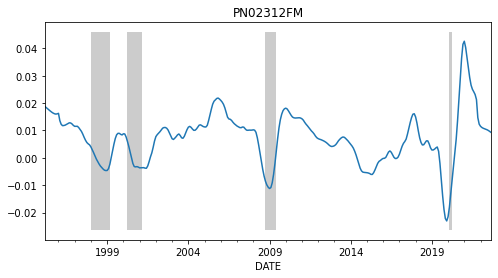

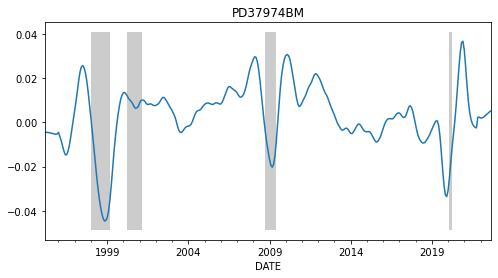

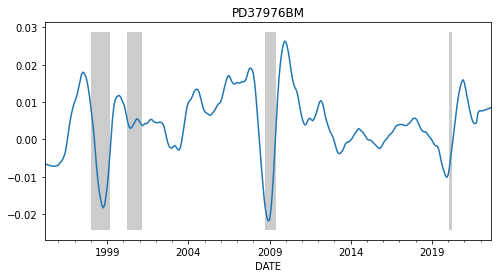

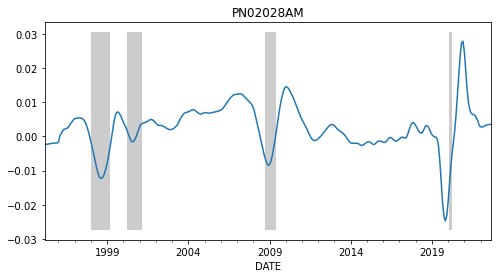

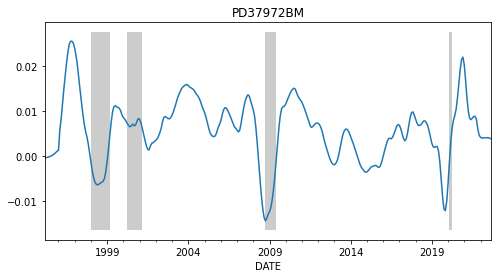

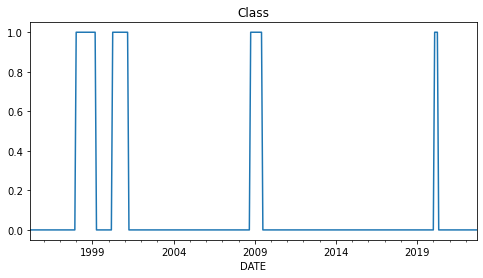

In [113]:
graficar_multiple(df_diff_sel)

Completar datos interpolando

In [114]:
df_diff_sel.head()

,PN02312FM,PD37974BM,PD37976BM,PN02028AM,PD37972BM,Class
DATE,,,,,,
1995-03-01,0.018757,-0.004451,-0.006579,-0.002390,-0.000309,0
1995-04-01,0.018362,-0.004446,-0.006674,-0.002311,-0.000265,0
1995-05-01,0.017922,-0.004494,-0.006794,-0.002235,-0.000201,0
1995-06-01,0.017489,-0.004590,-0.006922,-0.002158,-0.000108,0
1995-07-01,0.017076,-0.004723,-0.007032,-0.002082,0.000016,0


In [115]:
df_diff_sel.describe()

,PN02312FM,PD37974BM,PD37976BM,PN02028AM,PD37972BM,Class
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.007333,0.003140,0.004260,0.002553,0.005870,0.117825
std,0.009396,0.014114,0.008570,0.006737,0.007171,0.322889
min,-0.023065,-0.044618,-0.021834,-0.024735,-0.014352,0.000000
25%,0.001821,-0.004155,-0.000763,-0.001154,0.001794,0.000000
50%,0.007930,0.003949,0.004378,0.002729,0.006407,0.000000
75%,0.011984,0.010879,0.009684,0.006601,0.009957,0.000000
max,0.042614,0.036833,0.026307,0.027911,0.025603,1.000000


<AxesSubplot:xlabel='DATE'>

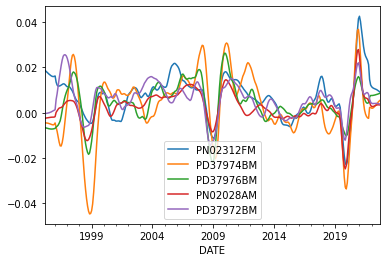

In [116]:
df_diff_sel.drop(labels=['Class'],axis=1).plot()

array([[<AxesSubplot:title={'center':'PN02312FM'}>,
        <AxesSubplot:title={'center':'PD37974BM'}>],
       [<AxesSubplot:title={'center':'PD37976BM'}>,
        <AxesSubplot:title={'center':'PN02028AM'}>],
       [<AxesSubplot:title={'center':'PD37972BM'}>,
        <AxesSubplot:title={'center':'Class'}>]], dtype=object)

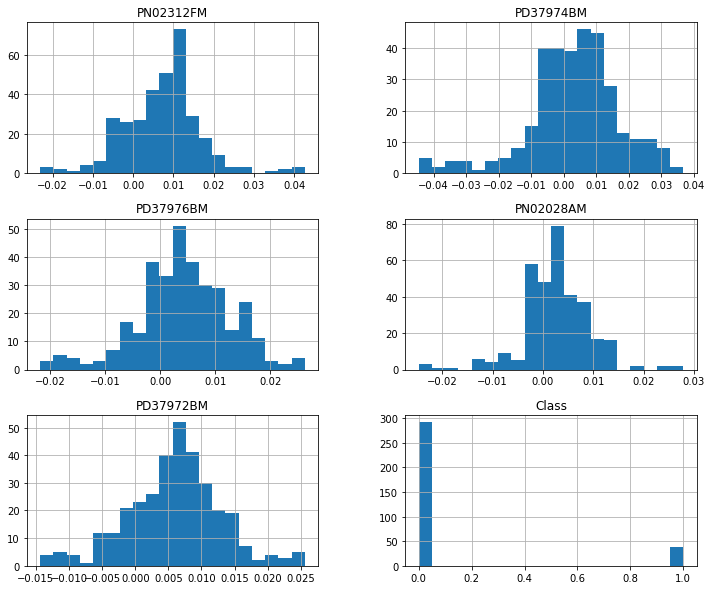

In [117]:
df_diff_sel.hist(figsize=[12,10], bins=20)

In [118]:
df_diff_sel.to_csv("../data/PERU_DATA_DIFF.csv")